In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import pandas as pd
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv(
    'Meetreeks_HVH.txt',
    delim_whitespace=True,
    header=None,
    names=['Date', 'Time', 'Elevation'])

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)

# Reorganize the DataFrame to have 'Datetime' as the first column
df = df[["Datetime", "Elevation"]]

df.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_76720\1021165046.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,Datetime,Elevation
0,1887-08-01 00:40:00,82
1,1887-08-01 13:10:00,72
2,1887-08-02 01:30:00,72
3,1887-08-02 14:20:00,72
4,1887-08-03 02:25:00,91


In [3]:
# Ensure Datetime is set as the index
df.set_index('Datetime', inplace=True)

# Add a 'Year' column for grouping
df['Year'] = df.index.year

# Calculate yearly averages
yearly_averages = df.groupby('Year')['Elevation'].mean()

# Map the yearly average back to the original DataFrame
df['Yearly_Avg'] = df['Year'].map(yearly_averages)

# Subtract the yearly average to obtain a stationary series
df['Elevation_Stationary'] = df['Elevation'] - df['Yearly_Avg']

# Drop the Year column if no longer needed
# df.drop(columns=['Year', 'Yearly_Avg'], inplace=True)

# Reset index if desired
df.reset_index(inplace=True)

print(df)


                 Datetime  Elevation  Year  Yearly_Avg  Elevation_Stationary
0     1887-08-01 00:40:00         82  1887   90.912162             -8.912162
1     1887-08-01 13:10:00         72  1887   90.912162            -18.912162
2     1887-08-02 01:30:00         72  1887   90.912162            -18.912162
3     1887-08-02 14:20:00         72  1887   90.912162            -18.912162
4     1887-08-03 02:25:00         91  1887   90.912162              0.087838
...                   ...        ...   ...         ...                   ...
94157 2020-12-29 14:15:00        130  2020  123.506365              6.493635
94158 2020-12-30 02:37:00        136  2020  123.506365             12.493635
94159 2020-12-30 14:46:00        148  2020  123.506365             24.493635
94160 2020-12-31 03:14:00        136  2020  123.506365             12.493635
94161 2020-12-31 15:27:00        144  2020  123.506365             20.493635

[94162 rows x 5 columns]


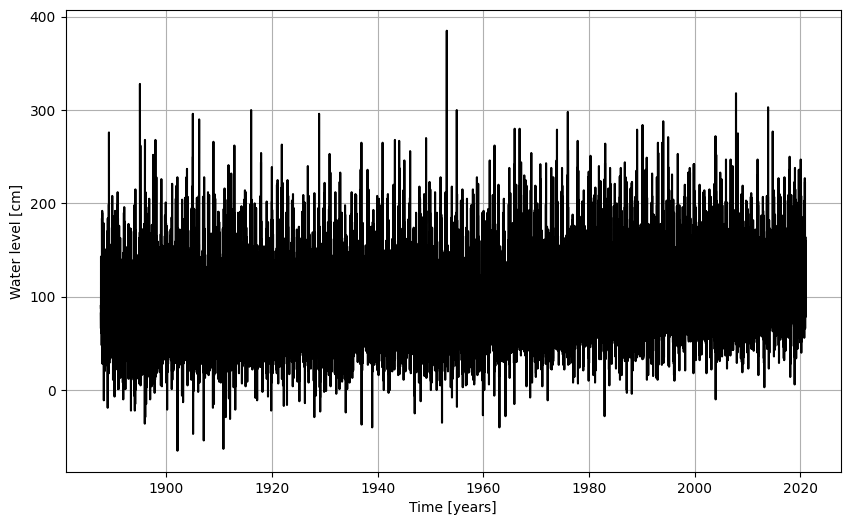

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
# plt.title('Water maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

5.312356215618939e-17


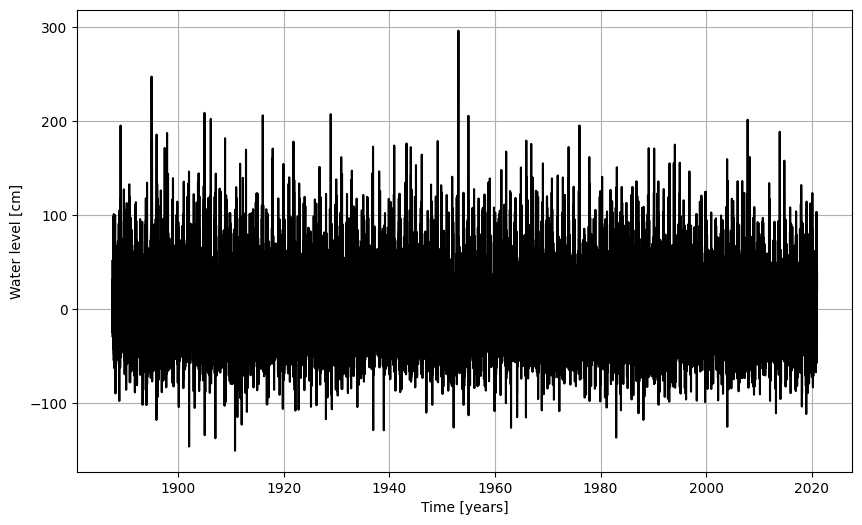

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation_Stationary"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
# plt.title('Water maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

print(df["Elevation_Stationary"].mean())

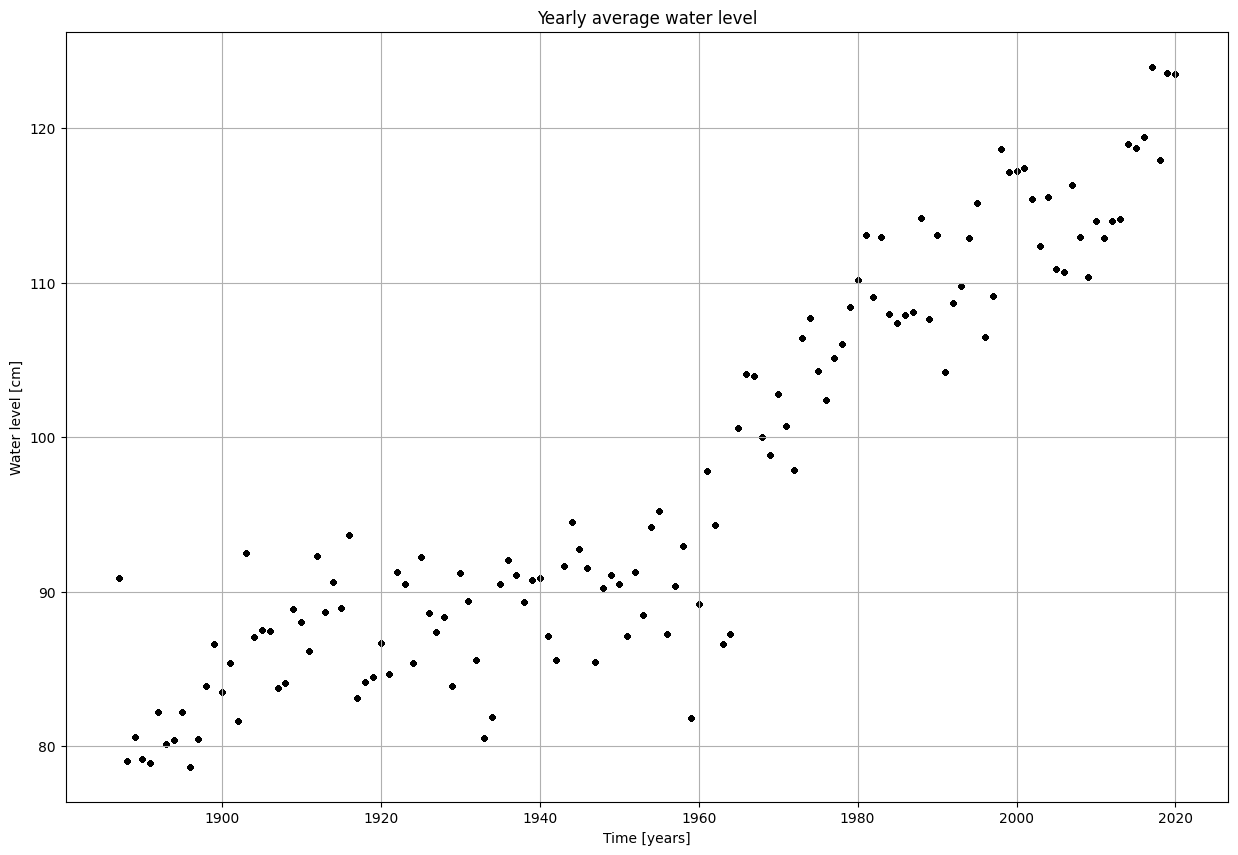

In [6]:
plt.figure(figsize=(15,10))
plt.scatter(df["Year"], df["Yearly_Avg"], color = 'black', marker= '.')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Yearly average water level')
plt.grid()
plt.savefig('figures/timeseries.png')

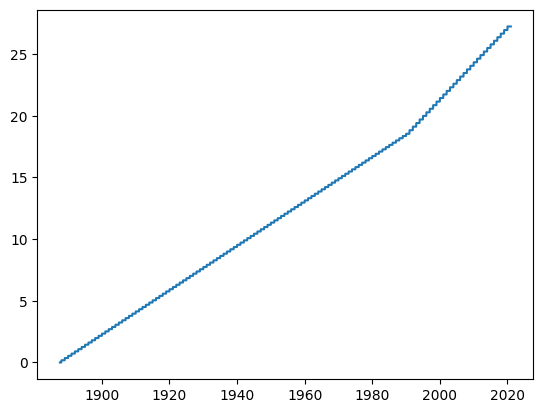

In [7]:
sea_level_correction = np.zeros(len(df["Elevation"]))
for i in range(len(sea_level_correction) - 1):
    if df["Datetime"][i+1].year != df["Datetime"][i].year:
        if df["Datetime"][i].year < 1990:
            sea_level_correction[i+1] = sea_level_correction[i] + 0.18
        else:
            sea_level_correction[i+1] = sea_level_correction[i] + 0.29
    else:
        sea_level_correction[i+1] = sea_level_correction[i]

plt.plot(df["Datetime"], sea_level_correction)

The shape of the sampled extremes is: (134, 5)


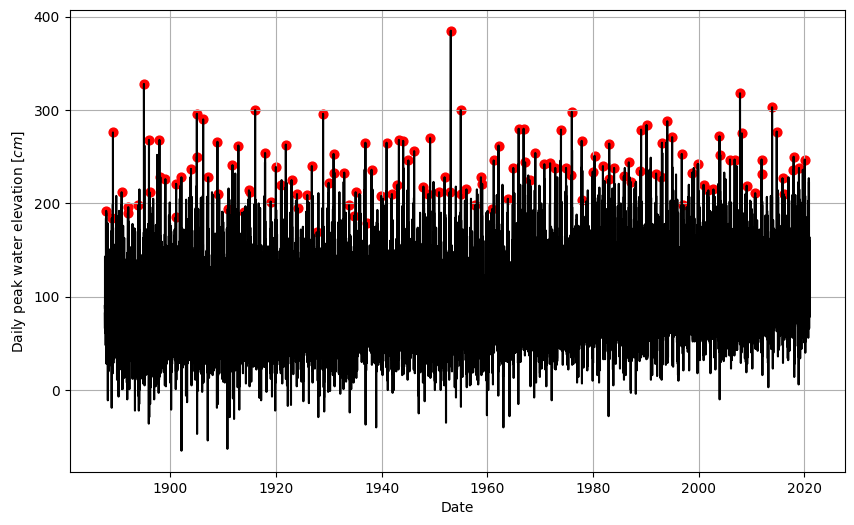

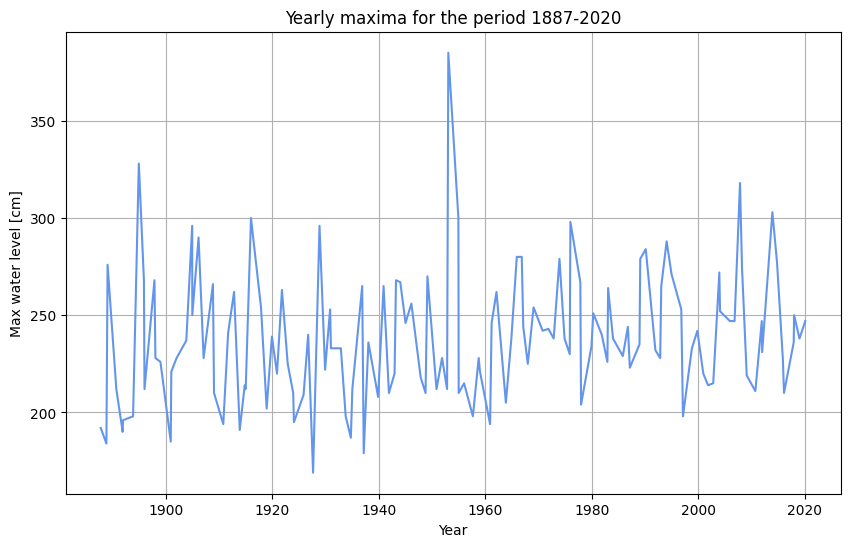

In [8]:
## Report yearly maxima for each year
idx_max = df.groupby(pd.DatetimeIndex(df['Datetime']).year)['Elevation'].idxmax()
YM = df.loc[idx_max]
print('The shape of the sampled extremes is:', YM.shape)

# Plot the yearly maxima on top of the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(YM['Datetime'], YM['Elevation'], 40, 'r')
plt.xlabel('Date')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.grid()
plt.savefig('figures/YM_timeseries.png')

## Plot the yearly maxima
plt.figure(figsize=(10,6))
plt.plot(YM['Datetime'], YM['Elevation'], color = 'cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Max water level [cm]')
plt.title('Yearly maxima for the period 1887-2020')
plt.grid()

**Additional explanation for the graph above:**
In the graph plotted above, the yearly maxima of waterlevels at Hoek van Holland are plotted. It can be observed that the maximum generally lie between 200-300 cm. At one instance, a very high peak was observed with a value of almost 400 cm. This point in time corresponds to the flood disaster of 1953, which flooded large parts of Zeeland and Zuid-Holland. 

Threshold defined: 200 m.
Declustering time is: 96 hours.
The shape of the sampled extremes is: (207,)


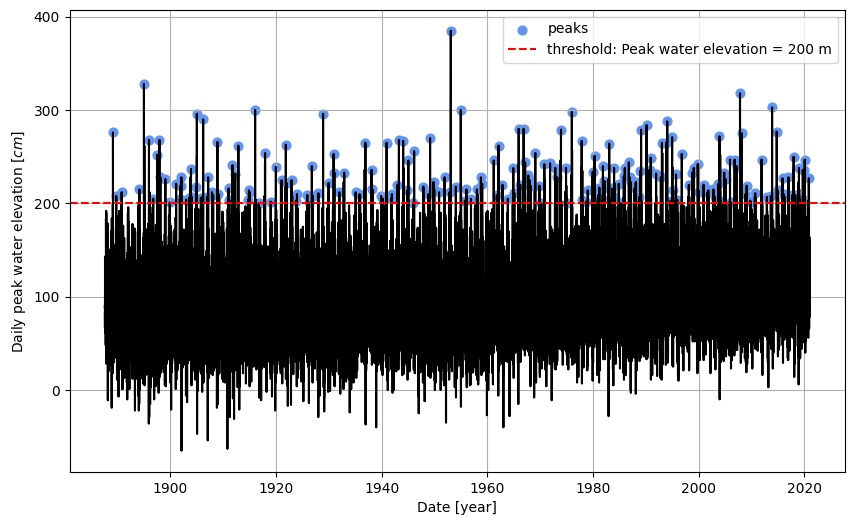

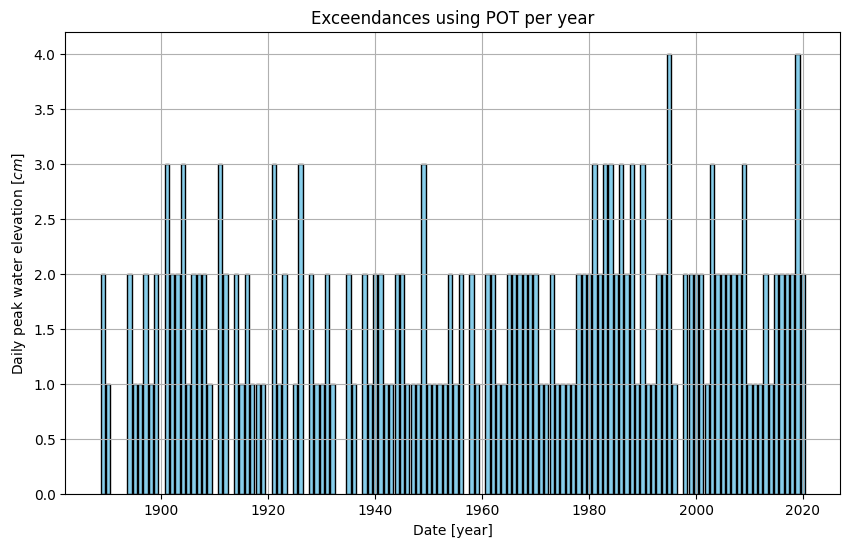

In [10]:
## Define the threshold
threshold = 200

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks_un, _ = find_peaks(df['Elevation'], height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks_un.shape)

peak_times_un = df['Datetime'].iloc[peaks_un]
exceedances_per_year = peak_times_un.groupby(peak_times_un.dt.year).size()

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(df.iloc[peaks_un, 0], df.iloc[peaks_un, 1], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water elevation = {threshold} m')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.legend()
# plt.title(f'Peaks selected by POT for dataset with a declustering time of {distance} hours') # title already in Google docs
plt.grid()
plt.savefig('figures/POT_timeseries.png')

plt.figure(figsize=(10,6))
plt.bar(exceedances_per_year.index, exceedances_per_year.values, color='skyblue', edgecolor='black')
plt.title('Exceendances using POT per year')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.grid()
plt.savefig('figures/POT_yearly_exc.png')

Threshold defined: 100 m.
Declustering time is: 96 hours.
The shape of the sampled extremes is: (208,)


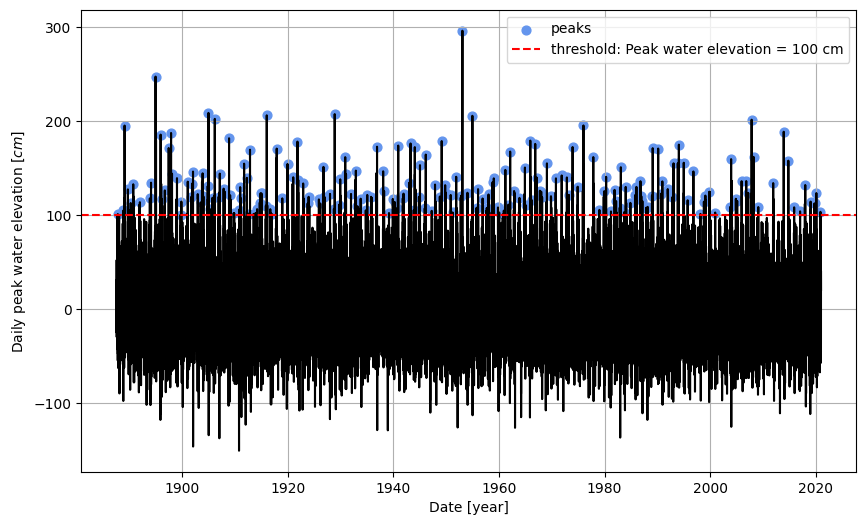

In [11]:
## Define the threshold
threshold = 100

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks, _ = find_peaks((df['Elevation_Stationary']), height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape)

peak_times = df['Datetime'].iloc[peaks]

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation_Stationary'],'k')
plt.scatter(df.iloc[peaks, 0], df.iloc[peaks, 4], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water elevation = {threshold} cm')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.legend()
# plt.title(f'Peaks selected by POT for dataset with a declustering time of {distance} hours') # title already in Google docs
plt.grid()
plt.savefig('figures/POT_timeseries.png')

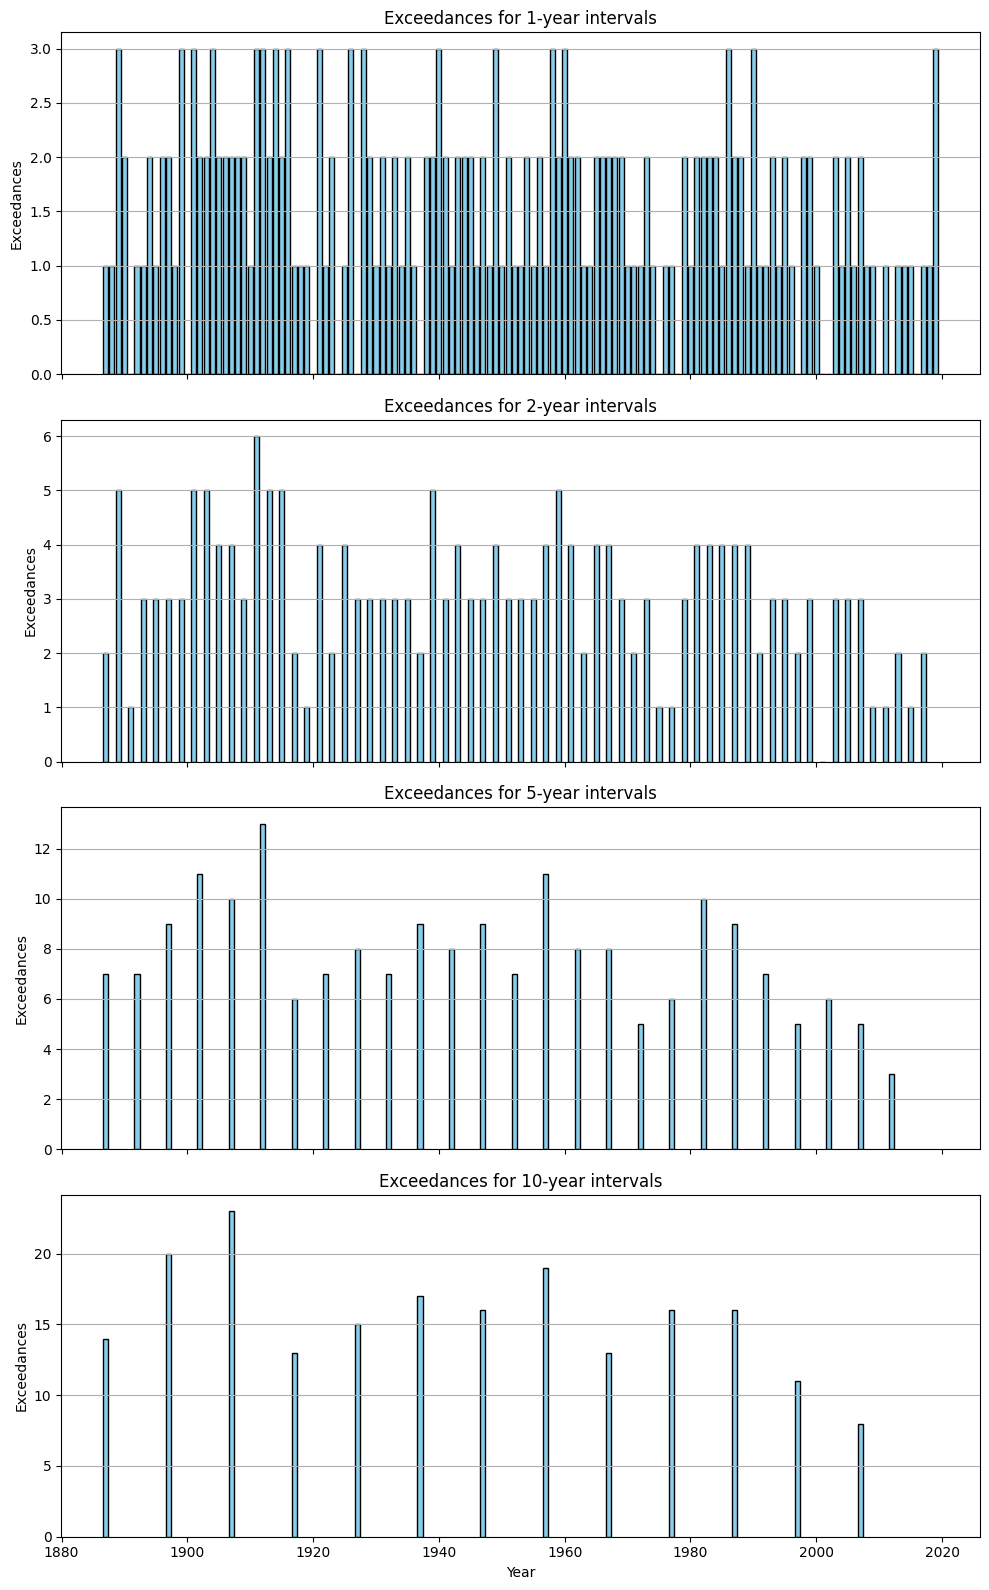

In [12]:
import matplotlib.pyplot as plt

# Define the intervals for grouping
intervals = [1, 2, 5, 10]  # years
results = {}

for interval in intervals:
    # Create bins based on the interval
    start_year = peak_times.dt.year.min()
    end_year = peak_times.dt.year.max()
    bins = range(start_year, end_year + 1, interval)
    
    # Group by bins
    peak_bins = pd.cut(peak_times.dt.year, bins=bins, right=False, labels=bins[:-1])
    exceedances = peak_bins.value_counts().sort_index()
    
    # Store the results for this interval
    results[f"{interval}-year"] = exceedances

# Plot the results
fig, axes = plt.subplots(len(intervals), 1, figsize=(10, len(intervals) * 4), sharex=True)

for i, (key, value) in enumerate(results.items()):
    axes[i].bar(value.index.astype(int), value.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Exceedances for {key} intervals")
    axes[i].set_ylabel("Exceedances")
    axes[i].grid(axis='y')

# Common X-axis label
axes[-1].set_xlabel("Year")

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Define the time difference threshold (e.g., two weeks = 14 days)
time_threshold = pd.Timedelta(days=14)

# Reset indices to ensure alignment
peak_times = peak_times.reset_index(drop=True)
time_differences = peak_times.diff()

# Find instances where the time difference is less than the threshold
close_extremes = time_differences[time_differences <= time_threshold]

# Get the indices of the peaks that are close to each other
close_extreme_indices = close_extremes.index

# Print the results
print(f"Number of close extremes: {len(close_extreme_indices)}")
print("Close extremes occurred at the following times:")
for idx in close_extreme_indices:
    print(f"- {peak_times[idx - 1]} and {peak_times[idx]} (Difference: {time_differences[idx]})")

# Optional: Filter the peaks DataFrame for closer inspection
close_extreme_pairs = pd.DataFrame({
    "First Peak": peak_times[close_extreme_indices - 1].values,
    "Second Peak": peak_times[close_extreme_indices].values,
    "Time Difference": time_differences[close_extreme_indices].values
})

# Display the DataFrame
print(close_extreme_pairs)

Number of close extremes: 0
Close extremes occurred at the following times:
Empty DataFrame
Columns: [First Peak, Second Peak, Time Difference]
Index: []


**Additional explanation for the graph above:**
In the upper graph, Peak Over Threshold is used to obtain extreme values for the water levels at Hoek van Holland. In this plot it can already be observed that the frequency of the exceedences increases after 1970. This is also visible in the lower graph, where the number of exceedences per year is plotted. In the last plot, the peaks are plotted over the total time series.

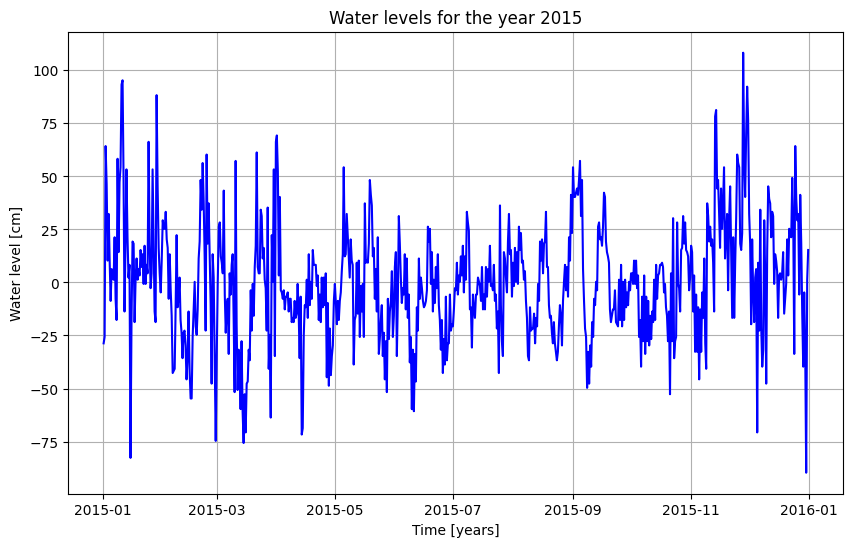

In [14]:
## Plot values for the year 2015
df_2015 = df[df['Datetime'].dt.year == 2015]
plt.figure(figsize=(10,6))
plt.plot(df_2015['Datetime'], df_2015['Elevation_Stationary'], color = 'blue')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Water levels for the year 2015')
plt.grid()

## Non-stationary analysis

**Non-stationary analysis**:The stochastic component is given by `df['Elevation_Stationary']`. We will fit an gev to the stochastic componant and derive the parameters of the distribution.

(-0.32131070407540474, 117.8907335953437, 15.900273474188946)


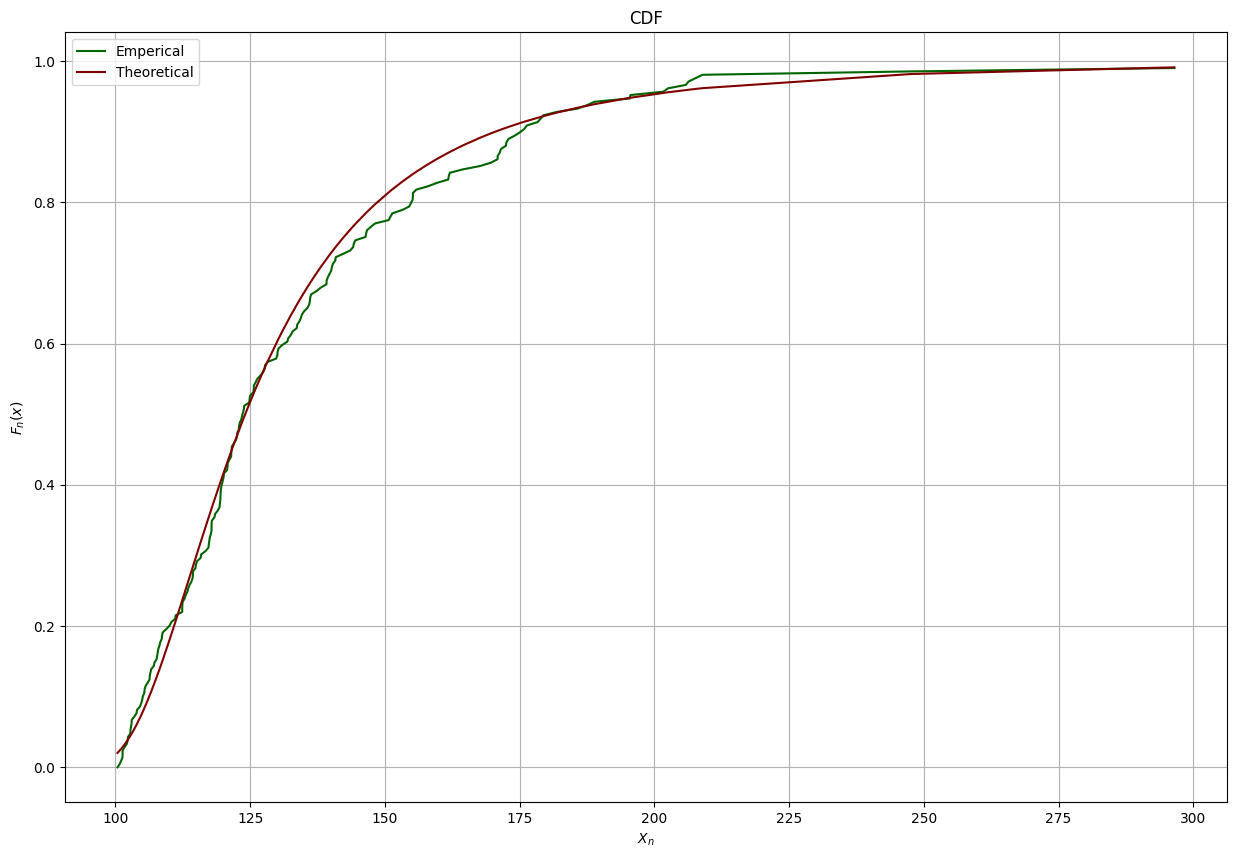

In [15]:
## Import necessary packages
from scipy import stats
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import genpareto as gpd

array = np.array(df.iloc[peaks, 4])

## Define the empirical CDF 
def ecdf(data):
    n = len(data)
    ecdf = []
    for i in range(0, n):
        ecdf.append(i / (len(data)+1))
    return ecdf

## Fit the GEV to the stochastic component
gev_par_stoch = gev.fit(array, loc = array.mean(), scale = array.std())
xi, mu, sigma = gev_par_stoch
print(gev_par_stoch)

## Plot the empirical and theoretical CDF
emperical = ecdf(np.sort(array))
theoretical = gev.cdf(np.sort(array), xi, mu, sigma)

plt.figure(figsize=(15,10))
plt.plot(np.sort(array), emperical, color = 'darkgreen', label = 'Emperical')
plt.plot(np.sort(array), theoretical, color = 'maroon', label = 'Theoretical')
plt.xlabel(r'$X_{n}$')
plt.ylabel(r'$F_{n}(x)$')
plt.title('CDF')
plt.grid()
plt.legend()
plt.show()

The parameters of the stationary signal have now been found and are the following:
- $\xi$ = -0.32131
- $\mu$ = 117.8907
- $\sigma$ = 15.900

From the yearly maxima signal it can be observed that the timeseries has to be devided into two distinctive parts, with both different relationships for the signal. The signal is devided up into before and after 1970. In other words, the non-stationary part will be added back into the signal.

[ 3.23115478e-01 -5.32923738e+02]
114.92279652319087
[200 200 200 201 201 202 202 203 203 203 204 204 204 205 207 207 207 207
 207 208 209 209 209 210 210 211 212 212 214 214 214 214 215 216 216 217
 217 219 220 220 221 221 223 223 224 226 227 227 228 228 228 228 229 231
 232 233 233 234 235 236 236 236 238 238 238 238 238 238 240 240 242 242
 243 244 247 247 247 247 249 250 251 253 264 265 265 267 271 272 275 277
 279 279 284 288 298 303 318]


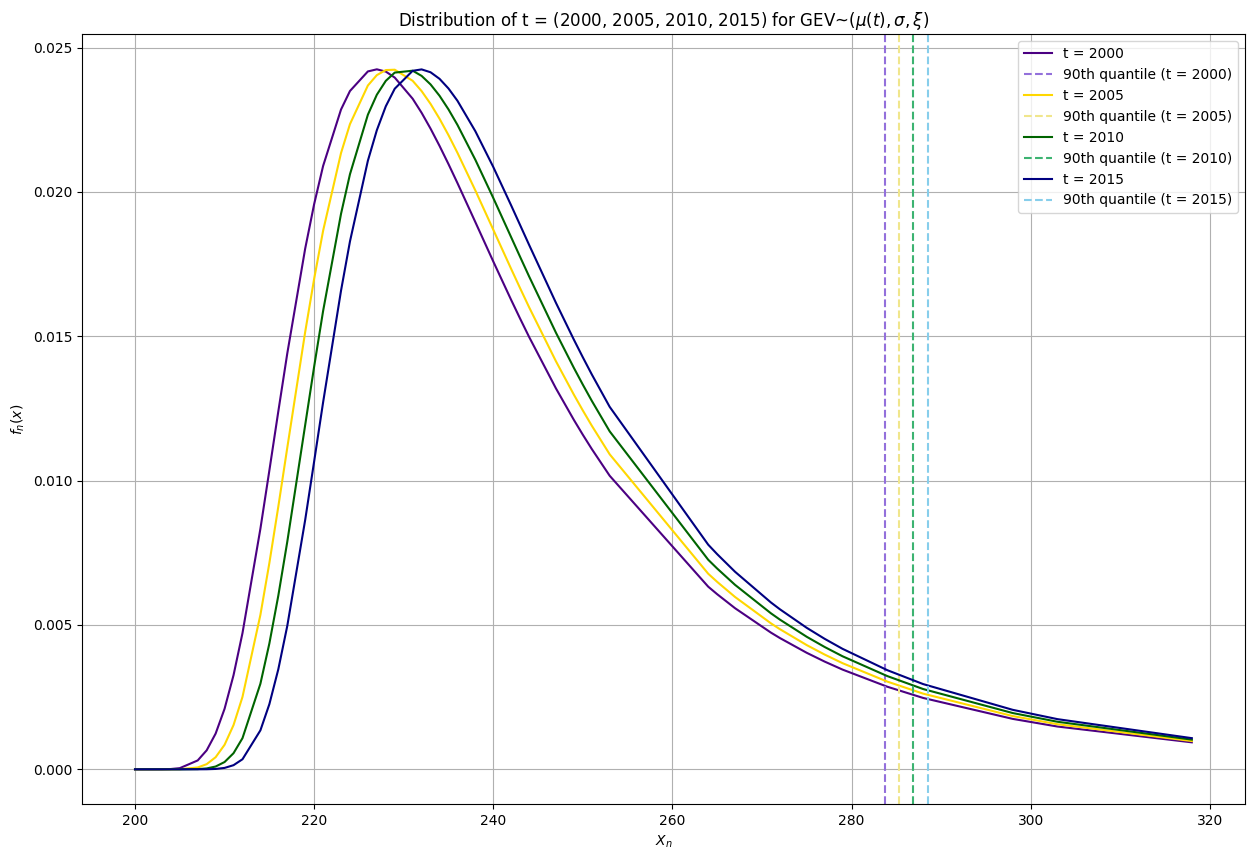

In [19]:
# Filter the DataFrame for dates after 1970
df_a1970 = df[df['Datetime'].dt.year >= 1970]
# Filter the yearly average for dates after 1970
YA_a1970 = df_a1970['Yearly_Avg']

## Linear fit will be found 
linmodel = np.polyfit(np.array(df_a1970['Year']), np.array(YA_a1970),1)
print(linmodel)
lin_new = np.poly1d(linmodel)
print(lin_new(2005))

## New mu value
mu0 = mu
def mu_new(t):
    mu_new = mu0 + lin_new(t)
    return mu_new

##
peaks_a1970 = np.array(peaks_un)[df.loc[peaks_un, 'Datetime'].dt.year >= 1970]
peaks_a1970_un = df.iloc[peaks_a1970, 1].values

## Calculate pdf for time step 2000, 2005, 2010, 2015
sorted_peaks = np.sort(np.array(peaks_a1970_un))
print(sorted_peaks)
f_mu2000 = gev.pdf(sorted_peaks, xi, mu_new(2000), sigma)
f_mu2005 = gev.pdf(sorted_peaks, xi, mu_new(2005), sigma)
f_mu2010 = gev.pdf(sorted_peaks, xi, mu_new(2010), sigma)
f_mu2015 = gev.pdf(sorted_peaks, xi, mu_new(2015), sigma)

## Find 90th quantile
quant90_2000 = gev.ppf(0.9, xi, mu_new(2000), sigma)
quant90_2005 = gev.ppf(0.9, xi, mu_new(2005), sigma)
quant90_2010 = gev.ppf(0.9, xi, mu_new(2010), sigma)
quant90_2015 = gev.ppf(0.9, xi, mu_new(2015), sigma)

## plot
plt.figure(figsize=(15,10))
plt.plot(sorted_peaks, f_mu2000, color = 'indigo', label = 't = 2000')
plt.axvline(x=quant90_2000, color = 'mediumpurple', linestyle = '--', label = '90th quantile (t = 2000)')
plt.plot(sorted_peaks, f_mu2005, color = 'gold', label = 't = 2005')
plt.axvline(x=quant90_2005, color = 'khaki', linestyle = '--', label = '90th quantile (t = 2005)')
plt.plot(sorted_peaks, f_mu2010, color = 'darkgreen', label = 't = 2010')
plt.axvline(x=quant90_2010, color = 'mediumseagreen', linestyle = '--', label = '90th quantile (t = 2010)')
plt.plot(sorted_peaks, f_mu2015, color = 'navy', label = 't = 2015')
plt.axvline(x=quant90_2015, color = 'skyblue', linestyle = '--', label = '90th quantile (t = 2015)')
plt.xlabel(r'$X_{n}$')
plt.ylabel(r'$f_{n}(x)$')
plt.title(r'Distribution of t = (2000, 2005, 2010, 2015) for GEV~($\mu(t), \sigma, \xi$)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
## Lets estimate the quantile for the year 2100
## For this we assume that the trend will not change for future t
quantiles_new = np.array([quant90_2000, quant90_2005, quant90_2010, quant90_2015])
t = np.array([2000, 2005, 2010, 2015])

#Find linear fit
linmodel2 = np.polyfit(t, quantiles_new, 1)
linfuture = np.poly1d(linmodel2)

## Find the 90th quantile for t = 2100
quant90_2100 = linfuture(2100)
print(f'The 90th quantile for the year 2100 is {quant90_2100:.3f}')
